# PCA Analysis for Elongation Prediction

## Why PCA for Elongation?

**Problem**: The dataset contains 50+ features including chemical composition, welding parameters, and process conditions. Many of these features are highly correlated.

**Why PCA is necessary**:

1. **Multicollinearity**: Chemical elements like C, Mn, Si are often correlated due to steel composition requirements. This creates redundant information and unstable model coefficients.

2. **Dimensionality Curse**: With sufficient samples and 50+ features, PCA reduces features while retaining 90-95% of variance, improving model generalization.

3. **Noise Reduction**: Minor variations in measurements contribute little to prediction but add noise. PCA captures systematic variation while filtering noise.

4. **Computational Efficiency**: Training models on 15-20 principal components is faster than 50+ original features, especially for GridSearchCV with cross-validation.

**About Elongation**: Elongation (%) measures the ductility of welded joints - the ability to deform plastically before fracture. It's a critical quality indicator for structural integrity and is influenced by microstructure, chemical composition, and welding parameters.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [ ]:
os.makedirs('pca_model', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [ ]:
df = pd.read_csv('../../welddatabase/welddb_pca.csv')
print(f"Prepared dataset shape: {df.shape}")

Prepared dataset shape: (1652, 52)


In [4]:
# Check Elongation data availability
elongation_available = df['Elongation_%'].notna().sum()
print(f"Elongation data available: {elongation_available} samples ({elongation_available/len(df)*100:.1f}%)")

Elongation data available: 700 samples (42.4%)


In [5]:
target_columns = ['Yield_Strength_MPa', 'UTS_MPa', 'Elongation_%', 
                  'Reduction_Area_%', 'Charpy_Temp_C', 'Charpy_Energy_J',
                  'Hardness_kg_mm2', 'FATT_50%', 'Primary_Ferrite_%',
                  'Ferrite_2nd_Phase_%', 'Acicular_Ferrite_%', 'Martensite_%',
                  'Ferrite_Carbide_%']

df_elong = df[df['Elongation_%'].notna()].copy()
y = df_elong['Elongation_%'].copy()
X = df_elong.drop(columns=target_columns)

print(f"Samples with Elongation: {len(df_elong)}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nElongation statistics:")
print(f"  Mean: {y.mean():.2f}%")
print(f"  Std: {y.std():.2f}%")
print(f"  Range: [{y.min():.2f}%, {y.max():.2f}%]")

Samples with Elongation: 700
Features shape: (700, 39)
Target shape: (700,)

Elongation statistics:
  Mean: -0.00%
  Std: 1.00%
  Range: [-3.20%, 2.19%]


## Feature Imputation

**Why KNN Imputer?**

KNN Imputer is robust to different missing data mechanisms (MCAR, MAR, MNAR) because:

1. **Non-parametric approach**: Makes no assumptions about data distribution or missing mechanism
2. **Local similarity**: Imputes based on similar samples, preserving relationships between features
3. **Handles correlations**: Leverages multivariate structure naturally present in welding data
4. **Distance-based weighting**: Closer neighbors contribute more, reducing noise from dissimilar samples

In [6]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = imputer.fit_transform(X)

print(f"Missing values after imputation: {pd.DataFrame(X_imputed).isnull().sum().sum()}")
print(f"Shape: {X_imputed.shape}")

Missing values after imputation: 0
Shape: (700, 39)


## PCA Variance Analysis

Data is already standardized, ready for PCA application.

In [7]:
pca_full = PCA()
pca_full.fit(X_imputed)

variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")

Components for 90% variance: 17
Components for 95% variance: 20


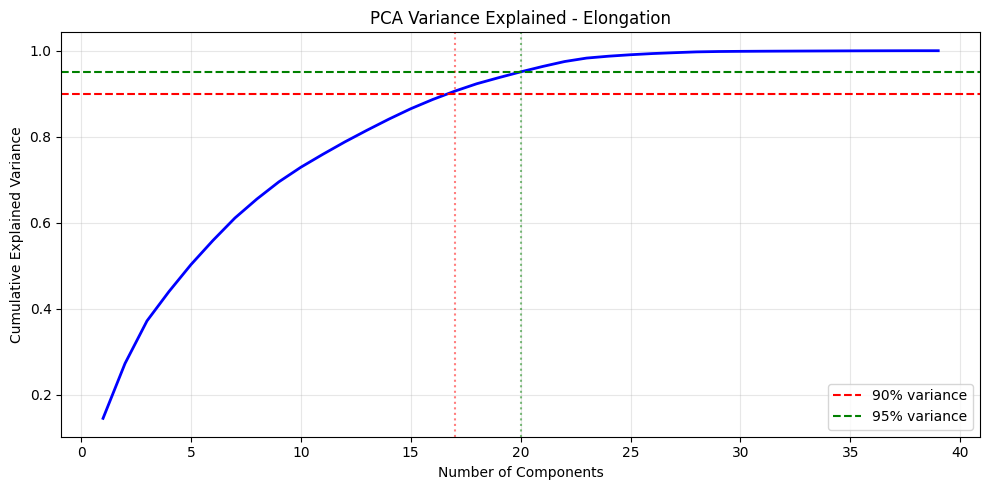

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-', linewidth=2)
ax.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
ax.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
ax.axvline(x=n_90, color='r', linestyle=':', alpha=0.5)
ax.axvline(x=n_95, color='g', linestyle=':', alpha=0.5)

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('PCA Variance Explained - Elongation')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

## Apply PCA with 90% Variance

In [9]:
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_imputed)

print(f"Original features: {X_imputed.shape[1]}")
print(f"PCA components: {X_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.4f}")

Original features: 39
PCA components: 17
Variance retained: 0.9060


In [27]:
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca['Elongation_%'] = y.values

df_pca.to_csv('data/welddb_pca_elongation.csv', index=False)
print(f"Shape: {df_pca.shape}")

Shape: (700, 18)


## Component Interpretation

In [11]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pc_columns,
    index=X.columns
)

print("Top 5 contributors to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head())

Top 5 contributors to PC1:
Tungsten_%          0.461666
Cobalt_%            0.424450
Nitrogen_weight%    0.354761
Chromium_%          0.315964
Silicon_%           0.226110
Name: PC1, dtype: float64


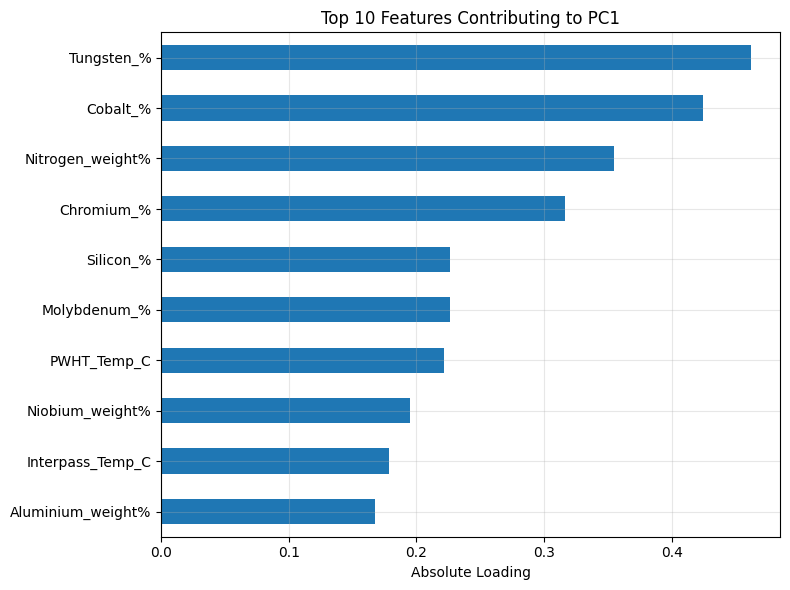

In [12]:
top_features_pc1 = loadings['PC1'].abs().nlargest(10)

fig, ax = plt.subplots(figsize=(8, 6))
top_features_pc1.sort_values().plot(kind='barh', ax=ax)
ax.set_xlabel('Absolute Loading')
ax.set_title('Top 10 Features Contributing to PC1')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pc1_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

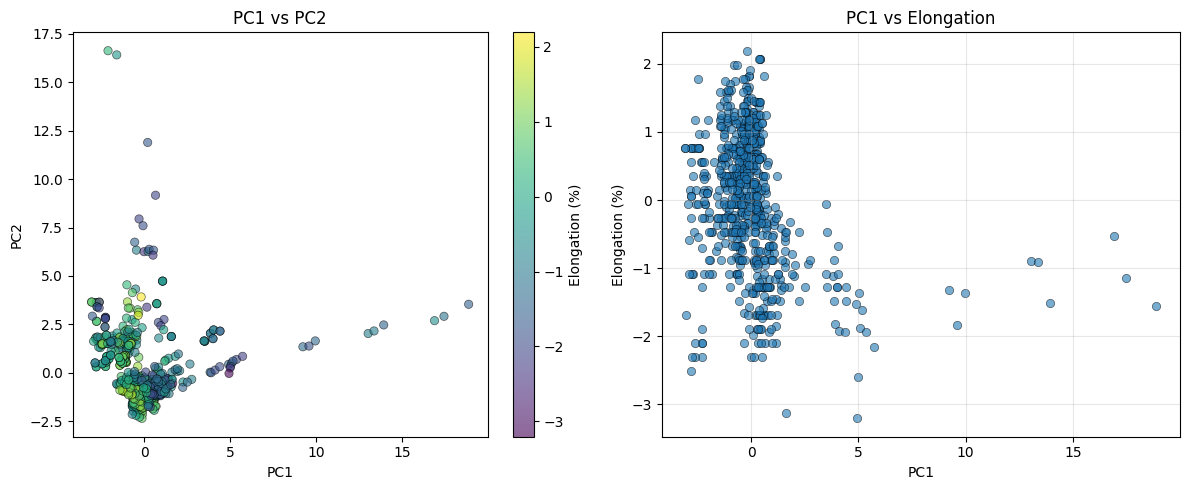

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Elongation_%'], 
                cmap='viridis', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PC1 vs PC2')
cbar1 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar1.set_label('Elongation (%)')

axes[1].scatter(df_pca['PC1'], df_pca['Elongation_%'], alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('Elongation (%)')
axes[1].set_title('PC1 vs Elongation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
correlation_with_target = df_pca.drop('Elongation_%', axis=1).corrwith(df_pca['Elongation_%'])
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

print("Top 5 PCs correlated with Elongation:")
print(correlation_with_target.head())

Top 5 PCs correlated with Elongation:
PC1     0.299711
PC9     0.259686
PC2     0.251786
PC6     0.208165
PC17    0.189238
dtype: float64


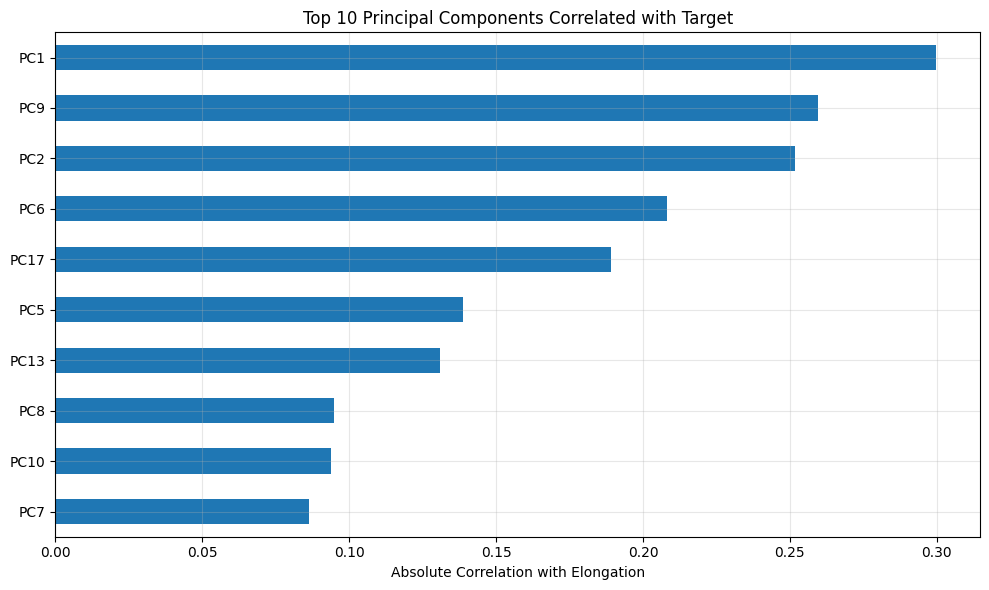

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
correlation_with_target.head(10).sort_values().plot(kind='barh', ax=ax)
ax.set_xlabel('Absolute Correlation with Elongation')
ax.set_title('Top 10 Principal Components Correlated with Target')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pc_target_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## Detailed Component Analysis

Analyze the contribution of each principal component to understand what information is captured.

In [16]:
# Individual variance contribution of each PC
variance_df = pd.DataFrame({
    'Component': pc_columns,
    'Variance_Explained': pca.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
})

print("Variance contribution by component:")
print(variance_df.head(10))
print(f"\nFirst 5 components capture: {variance_df['Cumulative_Variance'].iloc[4]:.2%} of variance")

Variance contribution by component:
  Component  Variance_Explained  Cumulative_Variance
0       PC1            0.145660             0.145660
1       PC2            0.127474             0.273134
2       PC3            0.098991             0.372124
3       PC4            0.068177             0.440301
4       PC5            0.062603             0.502904
5       PC6            0.056105             0.559009
6       PC7            0.052203             0.611212
7       PC8            0.044149             0.655361
8       PC9            0.039869             0.695231
9      PC10            0.033969             0.729199

First 5 components capture: 50.29% of variance


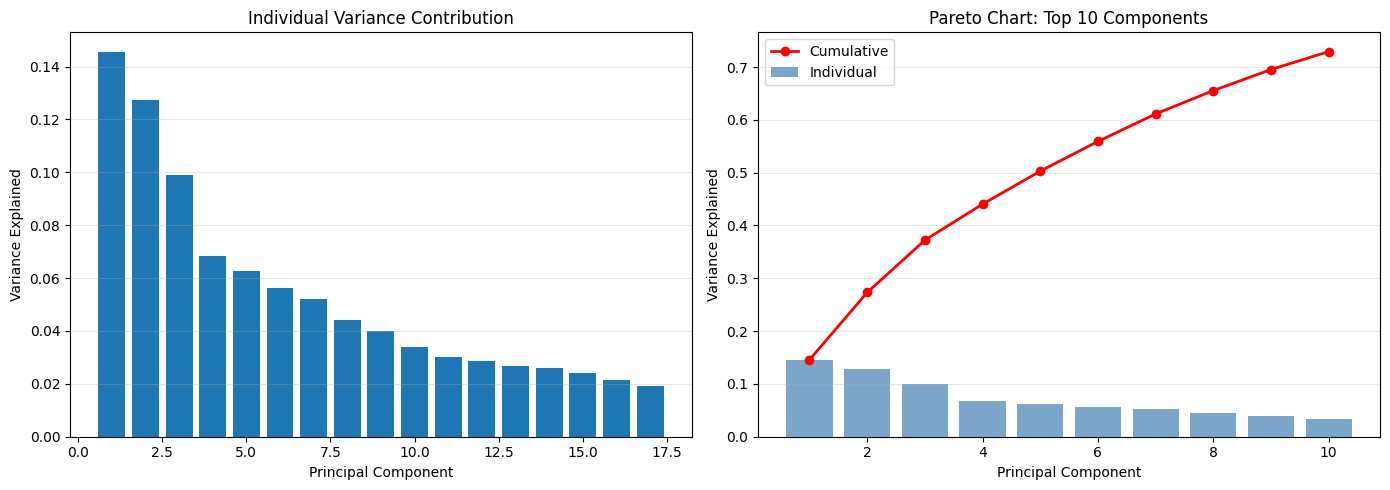

In [17]:
# Visualize individual variance contribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of variance
axes[0].bar(range(1, len(pc_columns) + 1), pca.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Individual Variance Contribution')
axes[0].grid(True, alpha=0.3, axis='y')

# Pareto chart (top 10)
top_10_var = pca.explained_variance_ratio_[:10]
top_10_cum = np.cumsum(top_10_var)
x_pos = np.arange(1, 11)

axes[1].bar(x_pos, top_10_var, color='steelblue', alpha=0.7, label='Individual')
axes[1].plot(x_pos, top_10_cum, 'ro-', linewidth=2, label='Cumulative')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained')
axes[1].set_title('Pareto Chart: Top 10 Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/variance_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Contributions Heatmap

Visualize how original features contribute to the first principal components.

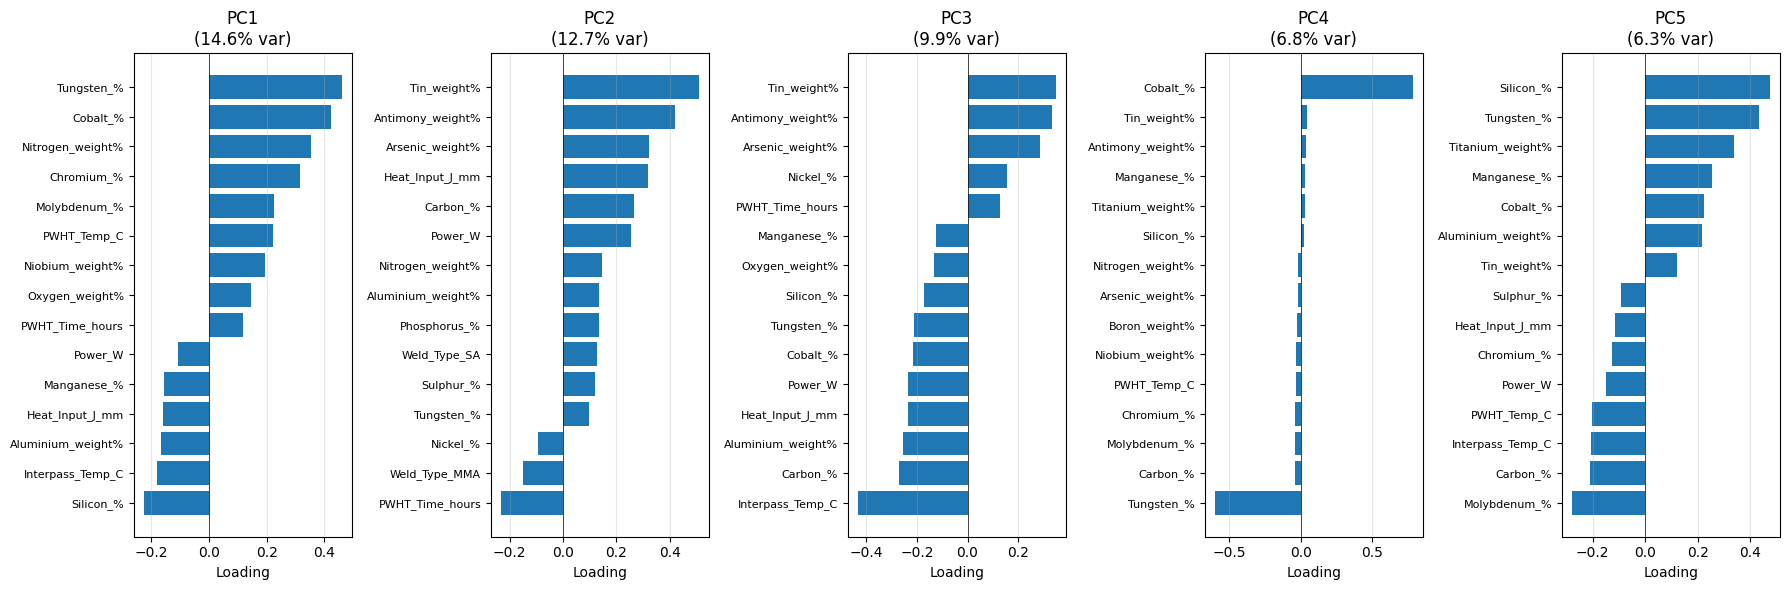

In [18]:
# Show top contributing features for first 5 PCs
n_components_to_show = min(5, len(pc_columns))
n_features_to_show = 15

fig, axes = plt.subplots(1, n_components_to_show, figsize=(18, 6))

for i in range(n_components_to_show):
    top_features = loadings[f'PC{i+1}'].abs().nlargest(n_features_to_show)
    top_features_sorted = loadings.loc[top_features.index, f'PC{i+1}'].sort_values()
    
    axes[i].barh(range(len(top_features_sorted)), top_features_sorted.values)
    axes[i].set_yticks(range(len(top_features_sorted)))
    axes[i].set_yticklabels(top_features_sorted.index, fontsize=8)
    axes[i].set_xlabel('Loading')
    axes[i].set_title(f'PC{i+1}\n({pca.explained_variance_ratio_[i]:.1%} var)')
    axes[i].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/pc_feature_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

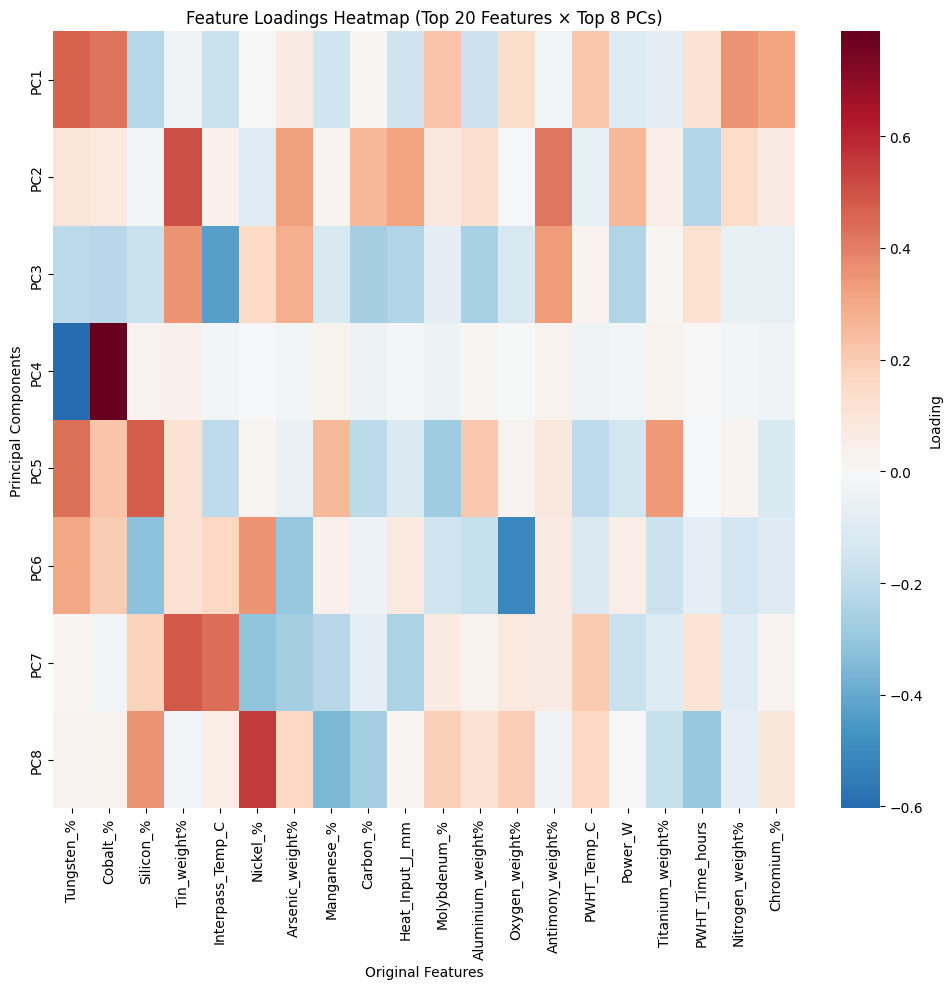

In [20]:
# Heatmap of loadings for top PCs and features
n_pcs_heatmap = min(8, len(pc_columns))
pcs_to_show = pc_columns[:n_pcs_heatmap]
top_varying_features = loadings[pcs_to_show].abs().sum(axis=1).nlargest(20).index

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(loadings.loc[top_varying_features, pcs_to_show].T, 
            cmap='RdBu_r', center=0, annot=False, 
            cbar_kws={'label': 'Loading'}, ax=ax)
ax.set_title('Feature Loadings Heatmap (Top 20 Features × Top 8 PCs)')
ax.set_xlabel('Original Features')
ax.set_ylabel('Principal Components')

plt.tight_layout()
plt.savefig('figures/loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 3D Visualization of Principal Components

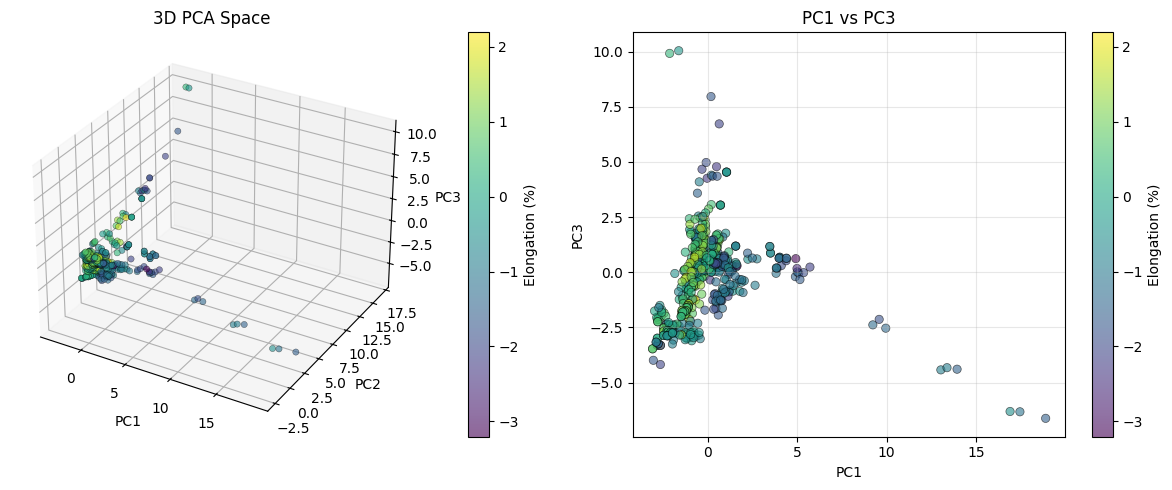

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

# 3D scatter plot
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                      c=df_pca['Elongation_%'], cmap='viridis', 
                      alpha=0.6, edgecolors='k', linewidth=0.3)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('3D PCA Space')
cbar = plt.colorbar(scatter, ax=ax1, pad=0.1)
cbar.set_label('Elongation (%)')

# Pair plot PC1 vs PC3
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(df_pca['PC1'], df_pca['PC3'], 
                       c=df_pca['Elongation_%'], cmap='viridis',
                       alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Elongation (%)')

plt.tight_layout()
plt.savefig('figures/pca_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

### Statistical Summary of PCA Components

In [22]:
# Statistical summary of PCA components
pc_stats = df_pca.drop('Elongation_%', axis=1).describe()
print("Statistical Summary of Principal Components:")
print(pc_stats.T.head(10))

# Distribution check - PCs should be normalized
print(f"\nMean of PC1: {df_pca['PC1'].mean():.6f}")
print(f"Std of PC1: {df_pca['PC1'].std():.6f}")

Statistical Summary of Principal Components:
      count          mean       std        min       25%       50%       75%  \
PC1   700.0 -3.045183e-17  2.061869  -3.073978 -0.775108 -0.153914  0.359149   
PC2   700.0  8.120488e-17  1.928866  -2.356122 -1.156649 -0.738279  0.831115   
PC3   700.0  0.000000e+00  1.699763  -6.622453 -0.885371  0.340408  0.780738   
PC4   700.0 -1.522592e-17  1.410620 -18.524795 -0.069154  0.023395  0.100291   
PC5   700.0 -2.030122e-17  1.351726  -3.086013 -0.566258 -0.017184  0.455276   
PC6   700.0  1.015061e-17  1.279651  -5.058025 -0.675458 -0.215318  0.929099   
PC7   700.0 -4.060244e-17  1.234358  -4.416961 -0.387111  0.162734  0.507148   
PC8   700.0  2.030122e-17  1.135149  -3.156515 -0.754039 -0.229161  0.445617   
PC9   700.0  2.283887e-17  1.078724  -3.161037 -0.588391 -0.116354  0.378154   
PC10  700.0 -6.090366e-17  0.995704  -3.351426 -0.461366 -0.055024  0.386402   

            max  
PC1   18.885171  
PC2   16.631408  
PC3   10.036187  
PC

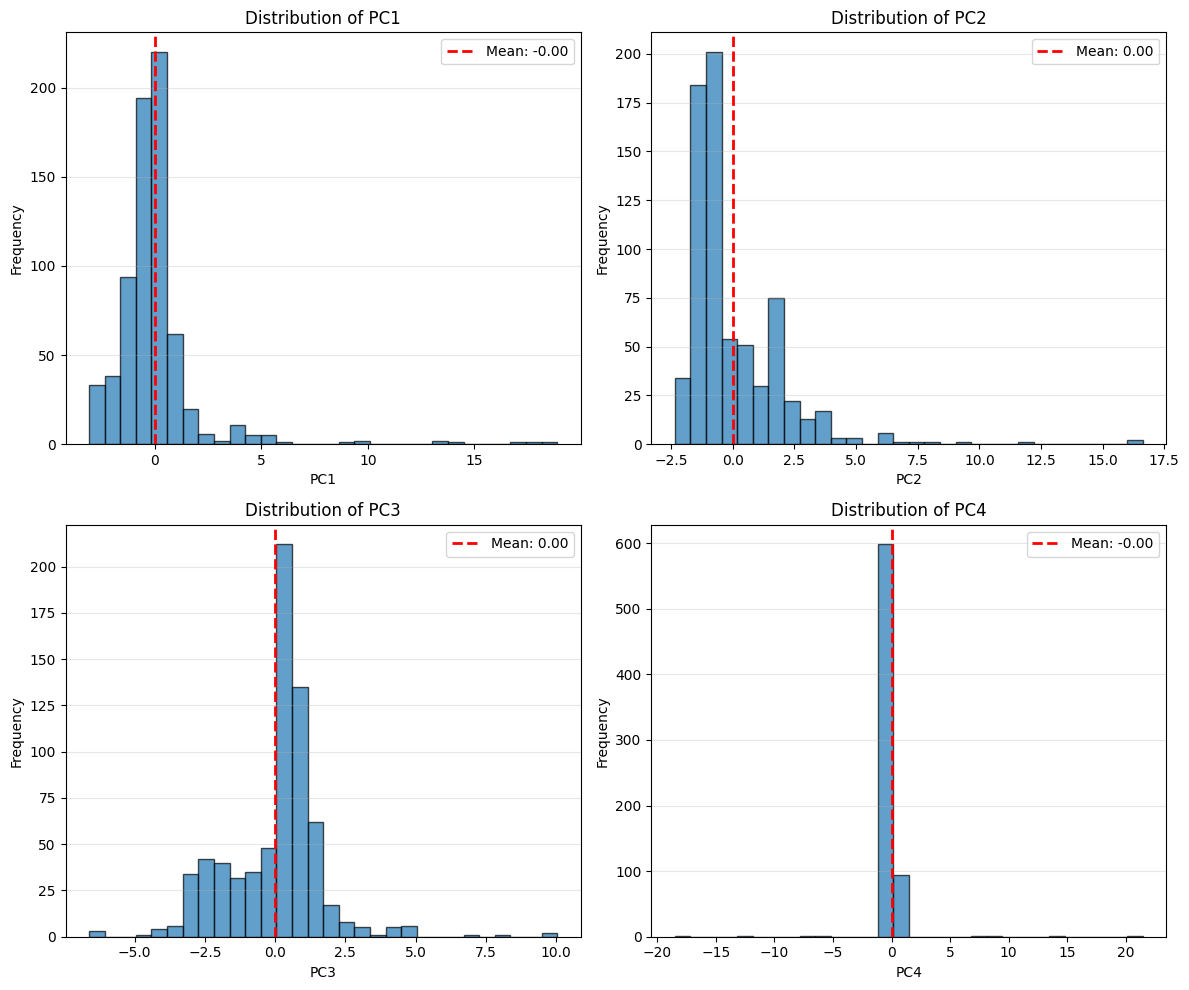

In [23]:
# Distribution plots for first 4 PCs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i in range(min(4, len(pc_columns))):
    axes[i].hist(df_pca[f'PC{i+1}'], bins=30, edgecolor='k', alpha=0.7)
    axes[i].axvline(df_pca[f'PC{i+1}'].mean(), color='r', linestyle='--', 
                    linewidth=2, label=f'Mean: {df_pca[f"PC{i+1}"].mean():.2f}')
    axes[i].set_xlabel(f'PC{i+1}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of PC{i+1}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/pc_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Reconstruction Error Analysis

How well can we reconstruct original features from PCA components?

In [24]:
# Reconstruct original features
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction error
reconstruction_error = np.mean((X_imputed - X_reconstructed) ** 2, axis=0)
reconstruction_df = pd.DataFrame({
    'Feature': X.columns,
    'Reconstruction_Error': reconstruction_error
}).sort_values('Reconstruction_Error', ascending=False)

print("Top 10 features with highest reconstruction error:")
print(reconstruction_df.head(10))

print(f"\nMean reconstruction error: {reconstruction_error.mean():.6f}")
print(f"Max reconstruction error: {reconstruction_error.max():.6f}")

Top 10 features with highest reconstruction error:
              Feature  Reconstruction_Error
0            Carbon_%              0.247309
17    Niobium_weight%              0.226147
15  Aluminium_weight%              0.220568
16      Boron_weight%              0.214624
22        PWHT_Temp_C              0.197341
14   Nitrogen_weight%              0.185389
3           Sulphur_%              0.131380
25    Heat_Input_J_mm              0.129492
7        Molybdenum_%              0.128593
24            Power_W              0.106522

Mean reconstruction error: 0.070272
Max reconstruction error: 0.247309


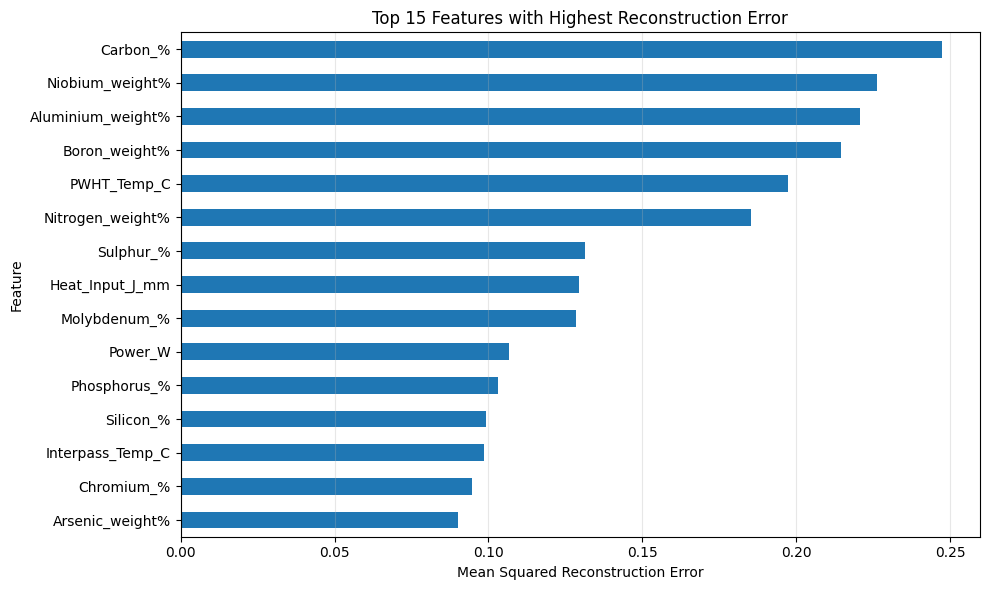

In [25]:
# Visualize reconstruction error
fig, ax = plt.subplots(figsize=(10, 6))
reconstruction_df.head(15).sort_values('Reconstruction_Error').plot(
    kind='barh', x='Feature', y='Reconstruction_Error', ax=ax, legend=False
)
ax.set_xlabel('Mean Squared Reconstruction Error')
ax.set_title('Top 15 Features with Highest Reconstruction Error')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/reconstruction_error.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Models

In [26]:
joblib.dump(pca, 'pca_model/pca_model.pkl')
joblib.dump(imputer, 'pca_model/imputer.pkl')

print("Saved PCA pipeline:")
print("- pca_model/pca_model.pkl")
print("- pca_model/imputer.pkl")

Saved PCA pipeline:
- pca_model/pca_model.pkl
- pca_model/imputer.pkl
